In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import os
#plt.style.use(['dark_background'])
ee.Initialize()

## create point feature

## Goal: Plot a time-series of GCVI from Sentinel-2 at one location in Zambia

In [3]:
pt_lon = 28.1511
pt_lat = -12.6258

ee_pt = ee.Geometry.Point([pt_lon, pt_lat]);

print("server side")
print(ee_pt)
print(type(ee_pt))

print("")

## .getInfo() brings data from server-side (ee objects) to client-side (Python objects)
print("client side")
print(ee_pt.getInfo())
print(type(ee_pt.getInfo()))

server side
ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Point",
    "arguments": {
      "coordinates": {
        "constantValue": [
          28.1511,
          -12.6258
        ]
      }
    }
  }
})
<class 'ee.geometry.Geometry'>

client side
{'type': 'Point', 'coordinates': [28.1511, -12.6258]}
<class 'dict'>


## Get Sentinel-2 data

In [8]:
start_date = '2020-10-01'
end_date = '2021-04-13'

s2_pt = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(ee_pt).filterDate(start_date, end_date)

print("There are {} scenes in the collection.".format(s2_pt.size().getInfo()))

There are 39 scenes in the collection.


## Get metadata for one scene

In [13]:
## get metadata for one scene
## must convert ImageCollection object to a list, then use .get().getInfo()
scenesList = s2_pt.toList(s2_pt.size());
sceneInfo = scenesList.get(38).getInfo()

type(sceneInfo)
sceneInfo.keys()

sceneInfo['bands']

[{'id': 'B1',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': 0,
   'max': 65535},
  'dimensions': [1830, 1830],
  'crs': 'EPSG:32735',
  'crs_transform': [60, 0, 600000, 0, -60, 8700040]},
 {'id': 'B2',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': 0,
   'max': 65535},
  'dimensions': [10980, 10980],
  'crs': 'EPSG:32735',
  'crs_transform': [10, 0, 600000, 0, -10, 8700040]},
 {'id': 'B3',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': 0,
   'max': 65535},
  'dimensions': [10980, 10980],
  'crs': 'EPSG:32735',
  'crs_transform': [10, 0, 600000, 0, -10, 8700040]},
 {'id': 'B4',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': 0,
   'max': 65535},
  'dimensions': [10980, 10980],
  'crs': 'EPSG:32735',
  'crs_transform': [10, 0, 600000, 0, -10, 8700040]},
 {'id': 'B5',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': 0,
   'max': 65535},
  'dimensions': [5490, 5490],
  'crs': 'E

## create functions for cloud masking, GCVI

In [16]:
# def cloudMask_s2(img):
#     quality = img.select(['pixel_qa'])
#     # clear = no clouds, cloud shadow
#     clear = (quality.bitwiseAnd(8).eq(0)) and (quality.bitwiseAnd(32).eq(0))  # cloud
#     return (img.updateMask(clear)
#            .copyProperties(img, ['system:index', 'system:time_start']))



def maskS2clouds(image):
    qa = image.select('QA60')

  ## Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

  ## Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

  ## Return the masked and scaled data, without the QA bands.
    return (image.updateMask(mask).divide(10000).select("B.*").copyProperties(image, ["system:time_start"]))



def addGCVI(image):
    gcvi = image.expression('(NIR / GREEN) - 1.0', {'NIR': image.select('B8'),'GREEN': image.select('B3')}).rename('GCVI');
    return(gcvi)    




In [17]:
s2_pt_masked_gcvi = s2_pt.map(maskS2clouds).map(addGCVI)
print(s2_pt_masked_gcvi.size().getInfo())

39


## extract time-series

In [18]:
import bokeh
import datetime
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

In [19]:
## put size of image collection in a Python variable (client-side)
length_ic = s2_pt_masked_gcvi.size().getInfo()
print('image collection size')
print(length_ic)

## set up Python arrays for date and for GCVI value
date_array = [-9999] * length_ic
gcvi_array = [-9999] * length_ic
print(gcvi_array)



image collection size
39
[-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999]


In [20]:
## iterate through image collection, extracting date and GCVI

## function for selecting singe image from image collection
def getImage(ee_ic, index):
    imageCollectionList = ee_ic.toList(ee_ic.size())
    image = imageCollectionList.get(index)
    return(ee.Image(image))




for i in range(length_ic):
    print(i)
    current_image = getImage(s2_pt_masked_gcvi, i)
    gcvi_array[i] = current_image.reduceRegion(reducer = ee.Reducer.mean(),
                                  geometry = ee_pt,
                                  scale = 10).get("GCVI").getInfo()
    date_array[i] = current_image.getInfo()['properties']['system:index'][0:8]
    
print(gcvi_array)
print(date_array)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
[0.9374149659863946, None, 1.1574585635359114, 0.9838383838383837, 1.0609037328094302, 0.965909090909091, 1.0812720848056538, 1.0772200772200775, None, 0.903225806451613, 1.194331983805668, 0.7035175879396984, None, None, None, None, None, None, None, 1.2335329341317367, None, None, None, 1.9090909090909092, None, 3.5216426193118755, 1.1217948717948718, None, None, None, None, None, None, 4.529605263157895, None, 0.4305084745762713, 4.674626865671641, 3.868462757527733, 0.35137034434293746]
['20201004', '20201009', '20201014', '20201019', '20201024', '20201029', '20201103', '20201108', '20201113', '20201118', '20201123', '20201128', '20201203', '20201208', '20201213', '20201218', '20201223', '20201228', '20210102', '20210107', '20210112', '20210117', '20210122', '20210127', '20210201', '20210206', '20210211', '20210216', '20210221', '20210226', '20210303', '20210308', '20210313', 

## Wrap this all in functions

In [21]:
def extractBandValue(ee_image, band_name, lon, lat):
    ee_point = ee.Geometry.Point([lon, lat])
    value = ee_image.reduceRegion(reducer = ee.Reducer.first(),
                                  geometry = ee_point,
                                  scale = 10).get(band_name).getInfo() # The scale determines the pyramid level from which to pull the input
    return(value)


def extractDate(ee_image):
    image_date_str = ee_image.getInfo()['properties']['system:index'][0:8]
    image_date = datetime.datetime(int(image_date_str[0:4]), int(image_date_str[4:6]), int(image_date_str[6:8]))
    return(image_date)


def extractTimeSeries(ee_ic, band_name, lon, lat):
    length_ic = ee_ic.size().getInfo()
    band_array = [-9999] * length_ic
    date_array = [-9999] * length_ic
    for i in range(length_ic):
        print(i)
        current_image = getImage(ee_ic, i)
        band_array[i] = extractBandValue(current_image, band_name, lon, lat)
        date_array[i] = extractDate(current_image)
    data_dict ={band_name: band_array, 'date': date_array}
    return(data_dict)


GCVI_ts = extractTimeSeries(s2_pt_masked_gcvi, 'GCVI', pt_lon, pt_lat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [22]:
print(GCVI_ts)

{'GCVI': [0.9374149659863946, None, 1.1574585635359114, 0.9838383838383837, 1.0609037328094302, 0.965909090909091, 1.0812720848056538, 1.0772200772200775, None, 0.903225806451613, 1.194331983805668, 0.7035175879396984, None, None, None, None, None, None, None, 1.2335329341317367, None, None, None, 1.9090909090909092, None, 3.5216426193118755, 1.1217948717948718, None, None, None, None, None, None, 4.529605263157895, None, 0.4305084745762713, 4.674626865671641, 3.868462757527733, 0.35137034434293746], 'date': [datetime.datetime(2020, 10, 4, 0, 0), datetime.datetime(2020, 10, 9, 0, 0), datetime.datetime(2020, 10, 14, 0, 0), datetime.datetime(2020, 10, 19, 0, 0), datetime.datetime(2020, 10, 24, 0, 0), datetime.datetime(2020, 10, 29, 0, 0), datetime.datetime(2020, 11, 3, 0, 0), datetime.datetime(2020, 11, 8, 0, 0), datetime.datetime(2020, 11, 13, 0, 0), datetime.datetime(2020, 11, 18, 0, 0), datetime.datetime(2020, 11, 23, 0, 0), datetime.datetime(2020, 11, 28, 0, 0), datetime.datetime(202

## convert GCVI time series to Pandas df

In [25]:
GCVI_df = pd.DataFrame(GCVI_ts)
#print(GCVI_df)

## filter data frame, remove NaN rows
GCVI_df_filt = GCVI_df.dropna()
print(GCVI_df_filt)

        GCVI       date
0   0.937415 2020-10-04
2   1.157459 2020-10-14
3   0.983838 2020-10-19
4   1.060904 2020-10-24
5   0.965909 2020-10-29
6   1.081272 2020-11-03
7   1.077220 2020-11-08
9   0.903226 2020-11-18
10  1.194332 2020-11-23
11  0.703518 2020-11-28
19  1.233533 2021-01-07
23  1.909091 2021-01-27
25  3.521643 2021-02-06
26  1.121795 2021-02-11
33  4.529605 2021-03-18
35  0.430508 2021-03-28
36  4.674627 2021-04-02
37  3.868463 2021-04-07
38  0.351370 2021-04-12


## plots

<AxesSubplot:xlabel='date'>

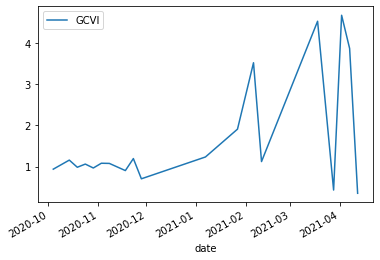

In [26]:
GCVI_df_filt.plot(x = 'date', y = 'GCVI')

<AxesSubplot:xlabel='date', ylabel='GCVI'>

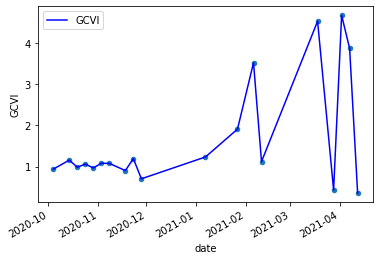

In [27]:
## show both a scatter plot and line plot

ax = GCVI_df_filt.plot.scatter(x = "date", y = "GCVI", style='b')
GCVI_df_filt.plot.line(x = "date", y = "GCVI", ax=ax, style='b')

## export data

In [28]:
print(os.getcwd())
GCVI_df_filt.to_csv('GCVI_df_filt.csv', header=True) 

/Users/michaelcecil/Rprojects/geog287387_s/materials/code/python
